# Analisi COVID

- Dovrai fare una presentazione dei dati rilevati usando tipo le relazioni di Arpa Lombardia e Piemonte, in modo da dare un quadro della situazione
- Obbiettivo: testare la tecnica per vedere come si comporta in questo caso (**deviazione al valore medio, DA PARLARNE**) e vedere se si possono notare delle differenze

-----------------------------------------------------

- Distortion to the mean
- Obbiettivo: Analizzare i dati dei mesi dell'epidemia COVID, che ha fortemente colpito la regione, per vedere se e come sono cambiate le concentrazioni registrate rispetto all'andamento degli anni 2015-2019. Valutare se e come la nostra tecnica abbia rilevato differenze e quindi queste differenze quali spunti potrebbero darci per potenziali interventi di miglioramento della qualità dell'aria

-----------------------------------------------------

- Sicuramente, usando i file dei capoluoghi già generati, puoi controllare le medie del periodo gennaio-maggio e vedere se si vedono differenze tra LE DUE SERIE NORMALIZZATE
- Sicuramente un lavoro di comparazione tra la serie normalizzata del periodo gennaioo 2020-maggio 2020 con quella dei valori reali registrati
- Provare a creare modello usando solo i dati dei mesi gennaio-maggio per la sua creazione

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import pandas as pd
import matplotlib.pyplot as plt
from AirNormalizer import AirNormalizer
import glob
pd.options.mode.chained_assignment = None
plt.rcParams['figure.figsize'] = [10, 7]

def get_data_covid(inquinante):
    files = glob.glob(f"{path}*{inquinante}.csv")
    dfs = []
    for file in files:
        data = pd.read_csv(file, parse_dates=["Data"], index_col="Data")
        dfs.append(data)
    tot = pd.concat(dfs).groupby("Data").mean()
    tot = tot[tot.index.year >= 2015]
    tot = tot[(tot.index.month >= 2) & (tot.index.month <= 5)]
    serie_storica, serie2020 = tot[tot.index.year <= 2019], tot[tot.index.year == 2020]
    datastart = min(serie_storica.index.year)
    serie_storica = serie_storica.groupby(serie_storica.index.dayofyear).mean()
    return (serie_storica, serie2020, datastart)

def get_data_covid_norm(inquinante):
    files = glob.glob(f"{path}*{inquinante}_normalizzato.csv")
    dfs = []
    for file in files:
        data = pd.read_csv(file, parse_dates=["Data"], index_col="Data")
        dfs.append(data)
    tot = pd.concat(dfs).groupby("Data").mean()
    tot = tot[tot.index.year >= 2015]
    tot = tot[(tot.index.month >= 2) & (tot.index.month <= 5)]
    serie_storica, serie2020 = tot[tot.index.year <= 2019], tot[tot.index.year == 2020]
    datastart = min(serie_storica.index.year)
    serie_storica = serie_storica.groupby(serie_storica.index.dayofyear).mean()
    return (serie_storica, serie2020, datastart)

path = "../data/tmp/"
inquinanti = ["NO2", "NOX", "PM10", "O3", "CO", "SO2", "PM2.5", "Benzene", "Ammoniaca"]
ticks_giorni = [60, 91, 121]
labels_giorni = ["Marzo", "Aprile", "Maggio"]
ticks_mesi = [2, 3, 4, 5]
labels_mesi = ["Febbraio", "Marzo", "Aprile", "Maggio"]

## TODO
- Aggiungi vline inizio quarantena
- Fai grafici medie mensili
- Fallo per tutti gli inquinanti e per ciascuno considera i settori maggiormente responsabili e le limitazioni che sono state imposte a causa del virus

#### Date DPCM
23-02 n62020 codogno e vò  
08-03 dpcm tutta la nazione  
11-03 chiusura tutte attività commerciali  
22-03 divieto di spostamento dal comune dove ci si trova  
04-05 attenuazione per due settimane  
18-05 ripartenza quasi normale  

-----------------------------------------------------------------

## Introduzione
- introduzione arpa piemonte sul perchè sia utile fare questo tipo di analisi: capire se i cali che si sono registrati nei mesi di marzo e aprile fossero solamente legati alla stagionalità o quanto in realtà abbiano influito le limitazioni imposte per il contenimento del COVID.
- le concentrazioni non sono direttamente collegate alle emissioni, perchè sono governate da sistemi molto più complessi di trasformazioni dovute a vari elementi
- arpa piemonte aveva provato a fare un lavoro di stima pesando le medie in base al calo previsto subito dalle principali attività responsabili di ciascun inquinante (categoria SNAP). Interessante comparare i risultati che otterremo

--------------------------------------------------------------------

# Analisi mesi epidemia COVID-19
I mesi primaverili del 2020 sono stati caratterizzati dalla diffusione dell'epidemia di Covid-19 e dalle importanti misure prese per il suo contenimento. Queste limitazioni hanno portato ad avere un quadro emissivo eccezionale per gli inquinanti atmosferici, che difficilmente si sarebbe potuto verificare in condizioni normali. Questi mesi, infatti, sono stati caratterizzati da importanti limitazioni sugli spostamenti e alle attività produttive, quindi rappresentano un importante banco di prove per verificare come siano cambiate le concentrazioni degli inquinanti in atmosfera con una così drastica riduzione delle attività antropiche, dandoci la possibilità di valutare come effettivamente si potrebbe intervenire per ottenere ulteriori miglioramenti della qualità dell'aria.

L'obbiettivo di questo notebook sarà quindi mettere alla prova la nostra tecnica di normalizzazione per vedere come siano effettivamente cambiate le concentrazioni degli inquinanti durante i mesi dell'epidemia rispetto agli anni precedenti, dopo aver eliminato la variabilità derivata dalle condizoni meteorologiche e stagionali.
È infatti importante considerare che l'epidemia è arrivata durante dei mesi che già normalmente sono abbastanza favorevoli per la maggior parte degli inquinanti di interesse, poichè le condizioni atmosferiche e meteorologiche dei mesi primaverili portano sempre ad un abbassamento delle concentrazioni misurate rispetto ai mesi invernali.  
Potendo eliminare la variabilità data dalla stagionalità e da queste condizioni meteorologiche che influenzano così tanto i valori misurati è quindi sicuramente interessante cercare di capire quanto i classici cali delle concentrazioni registrati nei mesi primaverili siano stati influenzati dal blocco generale avuto dalle attività umane in tali mesi.  

Andremo quindi a trattare tutti gli inquinanti, confrontando l'andamento dei mesi tra febbraio e maggio del 2020 con quello degli anni tra il 2015 e il 2019 della media delle serie, normalizzate e non, dei capoluoghi di provincia già usate per i notebook precedenti. In questo modo potremo verificare se per i mesi dell'epidemia il nostro modello ha rilevato dei cali riconducibili proprio alle limitazioni imposte, in modo da capire quale tipo di interventi possa risultare più efficacie per il contenimento delle concentrazioni di ciascuno.  
Per il calcolo delle medie delle serie useremo le due funzioni dichiarate ad inizio notebook, che recuperano i dati dai file "temporanei" creati in precedenza (e preparati dallo script di build).

## NOX e NO2
### NOX
Iniziamo le nostre analisi trattando gli ossidi di azoto che, viste le limitazioni agli spostamenti e considerato il loro collegamento con l'andamento del traffico, potrebbero essere potenzialmente gli inquinanti più colpiti durante questi mesi di lockdown. 
Ad influire, inoltre, potrebbe sicuramente essere stato anche il parziale calo delle emissioni industriali, dovuto al fermo delle attività non ritenute essenziali.

Usiamo quindi le funzioni dichiarate in precedenza per fare il confronto tra le annate e verificare quale sia stata la situazione nei mesi di lockdown.

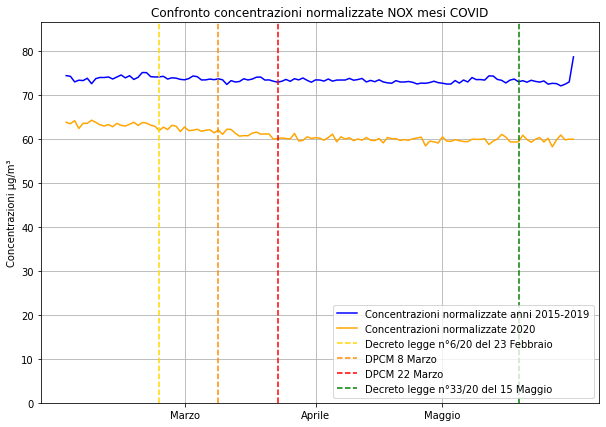

In [44]:
serie_storica_norm, serie2020_norm, datastart = get_data_covid_norm("NOX")
ymax = max([max(serie_storica_norm.inquinante), max(serie2020_norm.inquinante)])

plt.plot(serie_storica_norm.index, serie_storica_norm.inquinante, color="blue", label=f"Concentrazioni normalizzate anni {datastart}-2019")
plt.plot(serie2020_norm.index.dayofyear, serie2020_norm.inquinante, color="orange", label="Concentrazioni normalizzate 2020")
plt.axvline(54, linestyle="--", label="Decreto legge n°6/20 del 23 Febbraio", color="gold")
plt.axvline(68, linestyle="--", label="DPCM 8 Marzo", color="darkorange")
plt.axvline(82, linestyle="--", label="DPCM 22 Marzo", color="red")
plt.axvline(139, linestyle="--", label="Decreto legge n°33/20 del 15 Maggio", color="green")
plt.legend()
plt.grid()
plt.ylabel("Concentrazioni µg/m³")
plt.xticks(ticks=ticks_giorni, labels=labels_giorni)
plt.title("Confronto concentrazioni normalizzate NOX mesi COVID")
plt.ylim(0, ymax + (ymax / 10))
plt.show()

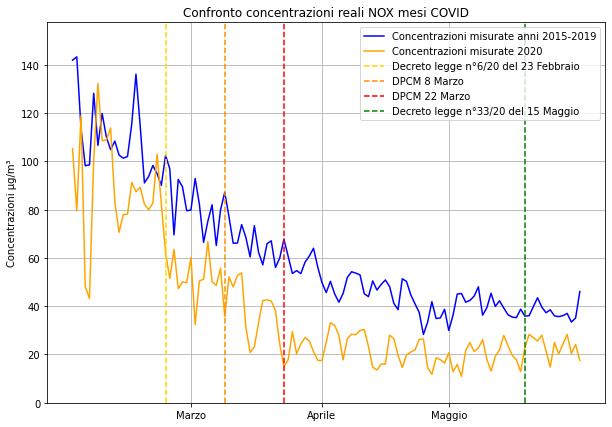

In [93]:
serie_storica, serie2020, datastart = get_data_covid("NOX")
ymax = max([max(serie_storica.inquinante), max(serie2020.inquinante)])

plt.plot(serie_storica.index, serie_storica.inquinante, color="blue", label=f"Concentrazioni misurate anni {datastart}-2019")
plt.plot(serie2020.index.dayofyear, serie2020.inquinante, color="orange", label="Concentrazioni misurate 2020")
plt.axvline(54, linestyle="--", label="Decreto legge n°6/20 del 23 Febbraio", color="gold")
plt.axvline(68, linestyle="--", label="DPCM 8 Marzo", color="darkorange")
plt.axvline(82, linestyle="--", label="DPCM 22 Marzo", color="red")
plt.axvline(139, linestyle="--", label="Decreto legge n°33/20 del 15 Maggio", color="green")
plt.legend()
plt.grid()
plt.ylabel("Concentrazioni µg/m³")
plt.xticks(ticks=ticks_giorni, labels=labels_giorni)
plt.title("Confronto concentrazioni reali NOX mesi COVID")
plt.ylim(0, ymax + (ymax / 10))
plt.show()

Guardando il grafico delle concentrazioni misurate si nota chiaramente il calo delle concentrazioni classico dei mesi primaverili, causato proprio dalle condizioni più favorevoli alla dispersione. Tale calo, chiaramente, risulta invece eliminato quando si considerano le serie normalizzate.  
Guardando sia i grafici delle concentrazioni reali che quello delle serie normalizzate si osserva come nei mesi di lockdown le concentrazioni abbiano subito un importante ribasso rispetto agli anni precedenti, sicuramente dovuto al blocco del traffico e di alcune attività produttive. 

### NO2
Verifichiamo anche i dati riguardanti il solo biossido di azoto, aspettandoci comunque di ottenere risultati abbastanza simili a quelli visti per gli ossidi.

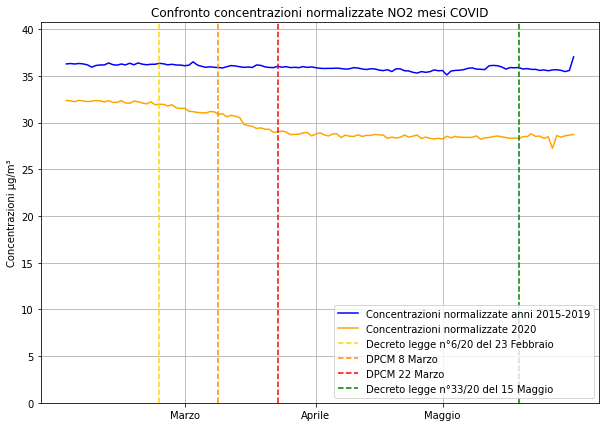

In [48]:
serie_storica_norm, serie2020_norm, datastart = get_data_covid_norm("NO2")
ymax = max([max(serie_storica_norm.inquinante), max(serie2020_norm.inquinante)])

plt.plot(serie_storica_norm.index, serie_storica_norm.inquinante, color="blue", label=f"Concentrazioni normalizzate anni {datastart}-2019")
plt.plot(serie2020_norm.index.dayofyear, serie2020_norm.inquinante, color="orange", label="Concentrazioni normalizzate 2020")
plt.axvline(54, linestyle="--", label="Decreto legge n°6/20 del 23 Febbraio", color="gold")
plt.axvline(68, linestyle="--", label="DPCM 8 Marzo", color="darkorange")
plt.axvline(82, linestyle="--", label="DPCM 22 Marzo", color="red")
plt.axvline(139, linestyle="--", label="Decreto legge n°33/20 del 15 Maggio", color="green")
plt.legend()
plt.grid()
plt.ylabel("Concentrazioni µg/m³")
plt.xticks(ticks=ticks_giorni, labels=labels_giorni)
plt.title("Confronto concentrazioni normalizzate NO2 mesi COVID")
plt.ylim(0, ymax + (ymax / 10))
plt.show()

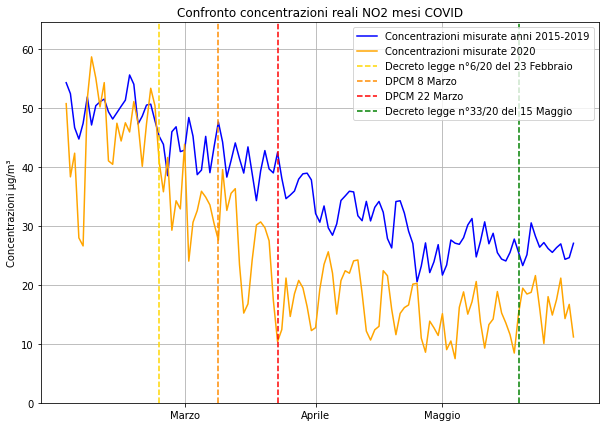

In [50]:
serie_storica, serie2020, datastart = get_data_covid("NO2")
ymax = max([max(serie_storica.inquinante), max(serie2020.inquinante)])

plt.plot(serie_storica.index, serie_storica.inquinante, color="blue", label=f"Concentrazioni misurate anni {datastart}-2019")
plt.plot(serie2020.index.dayofyear, serie2020.inquinante, color="orange", label="Concentrazioni misurate 2020")
plt.axvline(54, linestyle="--", label="Decreto legge n°6/20 del 23 Febbraio", color="gold")
plt.axvline(68, linestyle="--", label="DPCM 8 Marzo", color="darkorange")
plt.axvline(82, linestyle="--", label="DPCM 22 Marzo", color="red")
plt.axvline(139, linestyle="--", label="Decreto legge n°33/20 del 15 Maggio", color="green")
plt.legend()
plt.grid()
plt.ylabel("Concentrazioni µg/m³")
plt.xticks(ticks=ticks_giorni, labels=labels_giorni)
plt.title("Confronto concentrazioni reali NO2 mesi COVID")
plt.ylim(0, ymax + (ymax / 10))
plt.show()

Anche in questo caso, infatti, oltre al classico calo dei mesi primaverili, si vede una differenza tra le concentrazioni del 2020 e quelle degli anni precedenti, sia considerando le concentrazioni misurate che guardando le serie normalizzate.  
Anche in questo caso le cause sono sicuramente da attribuire alle stesse ragioni che hanno portato al calo degli ossidi.

Chiaramente questo tipo di misura non è sicuramente applicabile in modo continuo, ma ci dimostra come interventi su larga scala possano avere un discreto impatto sulle concentrazioni a differenza di quello che si era visto analizzando dei provvedimenti presi in particolari località, i cui effetti si sono rivelati minimi se non addirittura nulli.  
Interventi su larga scala richiederebbero investimenti sull'innovazione tecnologica, per poter arrivare ad avere una flotta di veicoli circolanti a bassissime emissioni, così come potrebbe essere sicuramente utile investire su motorizzazioni "pulite" come quella elettrica. Chiaramente questo tipo di interventi richiede tempo, soprattutto per quanto riguarda i motori elettrici che al momento presentano ancora diverse problematiche da risolvere, e ci dimostra come non sia possibile intervenire sugli inquinanti pensando di abbatterne le concentrazioni rapidamente.

## PM10 e PM2.5
Per quanto riguarda le polveri sottili e l'andamento delle concentrazioni nel periodo di lockdown la situazione risulta essere più complessa rispetto agli ossidi di azoto.  
Se da un lato, infatti, i cali di traffico e produzione industriale hanno sicuramente portato ad un calo delle emissioni, dall'altro si è visto un aumento di quelle derivanti da riscaldamenti domestici, causato da un maggior fabbisognio giornaliero delle famiglie costrette a restare più tempo nell'abitazione a causa delle misure imposte.  

Andiamo quindi a confrontare sia le concentrazioni normalizzate che i dati realmente rilevati dai sensori in campo, per vedere come il cambiamento del quadro emissivo di questo inquinante abbia portato anche ad un cambiamento delle concentrazioni misurate.

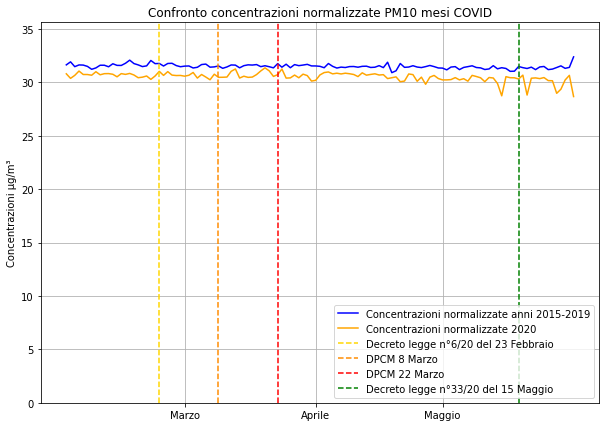

In [52]:
serie_storica_norm, serie2020_norm, datastart = get_data_covid_norm("PM10")
ymax = max([max(serie_storica_norm.inquinante), max(serie2020_norm.inquinante)])

plt.plot(serie_storica_norm.index, serie_storica_norm.inquinante, color="blue", label=f"Concentrazioni normalizzate anni {datastart}-2019")
plt.plot(serie2020_norm.index.dayofyear, serie2020_norm.inquinante, color="orange", label="Concentrazioni normalizzate 2020")
plt.axvline(54, linestyle="--", label="Decreto legge n°6/20 del 23 Febbraio", color="gold")
plt.axvline(68, linestyle="--", label="DPCM 8 Marzo", color="darkorange")
plt.axvline(82, linestyle="--", label="DPCM 22 Marzo", color="red")
plt.axvline(139, linestyle="--", label="Decreto legge n°33/20 del 15 Maggio", color="green")
plt.legend()
plt.grid()
plt.ylabel("Concentrazioni µg/m³")
plt.xticks(ticks=ticks_giorni, labels=labels_giorni)
plt.title("Confronto concentrazioni normalizzate PM10 mesi COVID")
plt.ylim(0, ymax + (ymax / 10))
plt.show()

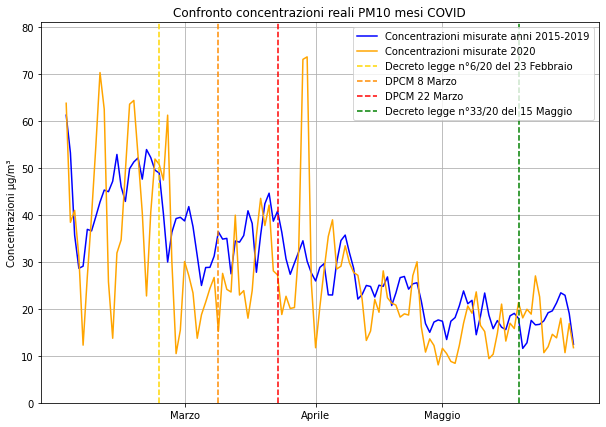

In [54]:
serie_storica, serie2020, datastart = get_data_covid("PM10")
ymax = max([max(serie_storica.inquinante), max(serie2020.inquinante)])

plt.plot(serie_storica.index, serie_storica.inquinante, color="blue", label=f"Concentrazioni misurate anni {datastart}-2019")
plt.plot(serie2020.index.dayofyear, serie2020.inquinante, color="orange", label="Concentrazioni misurate 2020")
plt.axvline(54, linestyle="--", label="Decreto legge n°6/20 del 23 Febbraio", color="gold")
plt.axvline(68, linestyle="--", label="DPCM 8 Marzo", color="darkorange")
plt.axvline(82, linestyle="--", label="DPCM 22 Marzo", color="red")
plt.axvline(139, linestyle="--", label="Decreto legge n°33/20 del 15 Maggio", color="green")
plt.legend()
plt.grid()
plt.ylabel("Concentrazioni µg/m³")
plt.xticks(ticks=ticks_giorni, labels=labels_giorni)
plt.title("Confronto concentrazioni reali PM10 mesi COVID")
plt.ylim(0, ymax + (ymax / 10))
plt.show()

Per quanto riguarda la frazione più spessa del particolato (PM10) vediamo come le concentrazioni misurate si mantengano piuttosto in linea con quanto visto negli anni precedenti, con episodi come quello di fine Marzo in cui le concentrazioni hanno fatto registrare valori ben al di sopra del limite di legge, nonostante fossero già in vigore tutte le limitazioni imposte coi vari DPCM per il contenimento dei contagi.  
La serie normalizzata, invece, evidenzia un leggero calo rispetto agli anni precedenti, che però potrebbe essere collegato al leggero trend decrescente che era già stato visto sulle serie normalizzate di questo inquinante.

Proviamo ad analizzare anche i dati riguardanti il PM2.5, anche se ci aspettiamo di ottenere dei risultati analoghi.

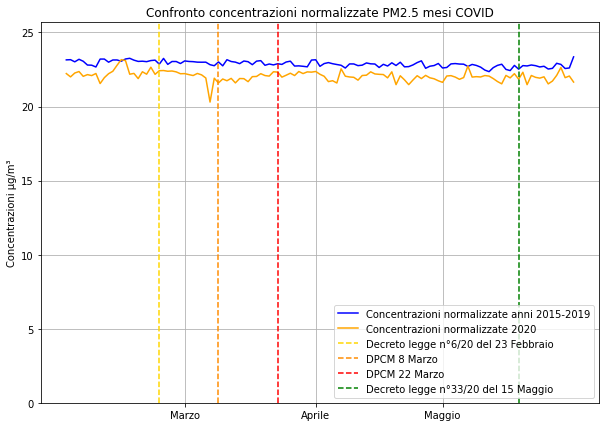

In [56]:
serie_storica_norm, serie2020_norm, datastart = get_data_covid_norm("PM2.5")
ymax = max([max(serie_storica_norm.inquinante), max(serie2020_norm.inquinante)])

plt.plot(serie_storica_norm.index, serie_storica_norm.inquinante, color="blue", label=f"Concentrazioni normalizzate anni {datastart}-2019")
plt.plot(serie2020_norm.index.dayofyear, serie2020_norm.inquinante, color="orange", label="Concentrazioni normalizzate 2020")
plt.axvline(54, linestyle="--", label="Decreto legge n°6/20 del 23 Febbraio", color="gold")
plt.axvline(68, linestyle="--", label="DPCM 8 Marzo", color="darkorange")
plt.axvline(82, linestyle="--", label="DPCM 22 Marzo", color="red")
plt.axvline(139, linestyle="--", label="Decreto legge n°33/20 del 15 Maggio", color="green")
plt.legend()
plt.grid()
plt.ylabel("Concentrazioni µg/m³")
plt.xticks(ticks=ticks_giorni, labels=labels_giorni)
plt.title("Confronto concentrazioni normalizzate PM2.5 mesi COVID")
plt.ylim(0, ymax + (ymax / 10))
plt.show()

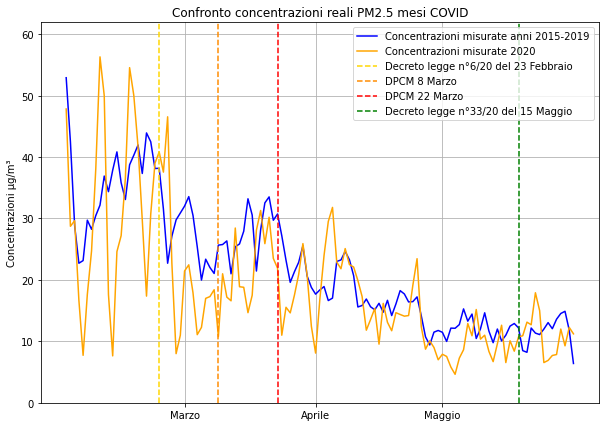

In [58]:
serie_storica, serie2020, datastart = get_data_covid("PM2.5")
ymax = max([max(serie_storica.inquinante), max(serie2020.inquinante)])

plt.plot(serie_storica.index, serie_storica.inquinante, color="blue", label=f"Concentrazioni misurate anni {datastart}-2019")
plt.plot(serie2020.index.dayofyear, serie2020.inquinante, color="orange", label="Concentrazioni misurate 2020")
plt.axvline(54, linestyle="--", label="Decreto legge n°6/20 del 23 Febbraio", color="gold")
plt.axvline(68, linestyle="--", label="DPCM 8 Marzo", color="darkorange")
plt.axvline(82, linestyle="--", label="DPCM 22 Marzo", color="red")
plt.axvline(139, linestyle="--", label="Decreto legge n°33/20 del 15 Maggio", color="green")
plt.legend()
plt.grid()
plt.ylabel("Concentrazioni µg/m³")
plt.xticks(ticks=ticks_giorni, labels=labels_giorni)
plt.title("Confronto concentrazioni reali PM2.5 mesi COVID")
plt.ylim(0, ymax + (ymax / 10))
plt.show()

Esattamente come visto in precedenza, anche per la frazione più fine di particolato le concentrazioni si mantengono abbastanza invariate rispetto agli anni precedenti, con una piccola discrepanza sulle serie normalizzate nuovamente dovuta alla presenza di un trend leggermente calante individuato per le serie normalizzate di questo inquinante,

Per quanto riguarda il particolato, quindi, nonostante la riduzione del traffico e delle attività produttive, il maggior fabbisogno energetico delle famiglie ha fatto sì che le concentrazioni rimanessero comunque su livelli più o meno simili a quelli degli anni precedenti.  
Questo ci mostra come effettivamente per trattare questi inquinanti, la cui origine è sicuramente varia e complessa, non si possano prendere provvedimenti riguardanti solamente un settore in particolare, come potrebbe essere il traffico, ma vanno pensati dei piani che riguardino tutte le fonti emissive.  
La presenza di un trend negativo per tutte e due le frazioni di particolato è sicuramente un'indicazione che comunque la strada che si sta percorrendo negli ultimi anni sia quella giusta e che sia necessario proseguire investendo sempre di più su innovazione tecnologica e fonti rinnovabili.

## CO
Anche per quanto riguarda il monossido di carbonio il quadro emissivo è cambiato durante i mesi dell'epidemia, con l'importante riduzione del traffico che però anche in questo caso è stata bilanciata dal maggior uso dei riscaldamenti domestici. Traffico e combustioni non industriali, infatti, sono le due categorie maggiormente responsabili delle emissioni di questo inquinante in atmosfera.

Proviamo a fare il confronto con gli anni precedenti già visto per gli altri inquinanti per vedere quali siano stati gli effetti dei mesi di lockdown sulle concentrazioni di questo inquinante.

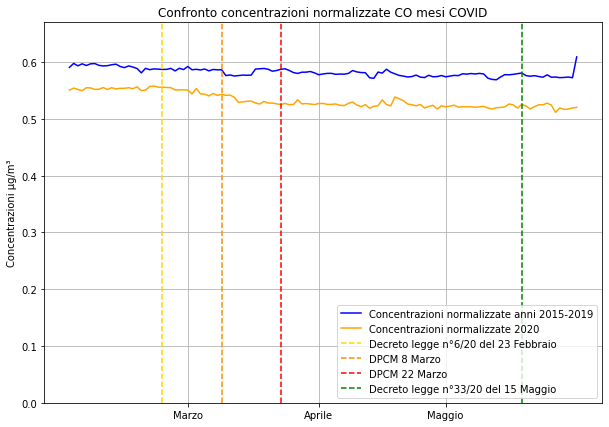

In [60]:
serie_storica_norm, serie2020_norm, datastart = get_data_covid_norm("CO")
ymax = max([max(serie_storica_norm.inquinante), max(serie2020_norm.inquinante)])

plt.plot(serie_storica_norm.index, serie_storica_norm.inquinante, color="blue", label=f"Concentrazioni normalizzate anni {datastart}-2019")
plt.plot(serie2020_norm.index.dayofyear, serie2020_norm.inquinante, color="orange", label="Concentrazioni normalizzate 2020")
plt.axvline(54, linestyle="--", label="Decreto legge n°6/20 del 23 Febbraio", color="gold")
plt.axvline(68, linestyle="--", label="DPCM 8 Marzo", color="darkorange")
plt.axvline(82, linestyle="--", label="DPCM 22 Marzo", color="red")
plt.axvline(139, linestyle="--", label="Decreto legge n°33/20 del 15 Maggio", color="green")
plt.legend()
plt.grid()
plt.ylabel("Concentrazioni µg/m³")
plt.xticks(ticks=ticks_giorni, labels=labels_giorni)
plt.title("Confronto concentrazioni normalizzate CO mesi COVID")
plt.ylim(0, ymax + (ymax / 10))
plt.show()

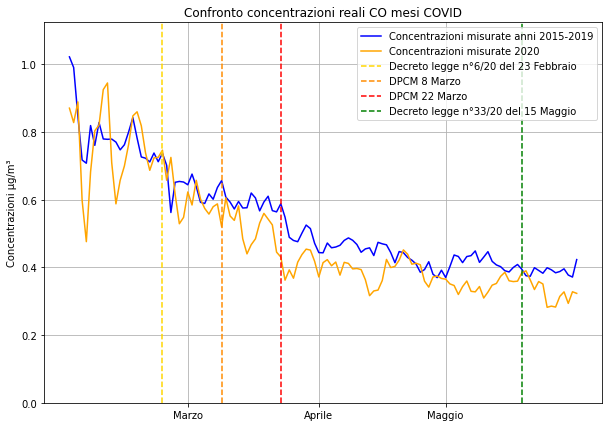

In [62]:
serie_storica, serie2020, datastart = get_data_covid("CO")
ymax = max([max(serie_storica.inquinante), max(serie2020.inquinante)])

plt.plot(serie_storica.index, serie_storica.inquinante, color="blue", label=f"Concentrazioni misurate anni {datastart}-2019")
plt.plot(serie2020.index.dayofyear, serie2020.inquinante, color="orange", label="Concentrazioni misurate 2020")
plt.axvline(54, linestyle="--", label="Decreto legge n°6/20 del 23 Febbraio", color="gold")
plt.axvline(68, linestyle="--", label="DPCM 8 Marzo", color="darkorange")
plt.axvline(82, linestyle="--", label="DPCM 22 Marzo", color="red")
plt.axvline(139, linestyle="--", label="Decreto legge n°33/20 del 15 Maggio", color="green")
plt.legend()
plt.grid()
plt.ylabel("Concentrazioni µg/m³")
plt.xticks(ticks=ticks_giorni, labels=labels_giorni)
plt.title("Confronto concentrazioni reali CO mesi COVID")
plt.ylim(0, ymax + (ymax / 10))
plt.show()

Successivamente all'applicazione delle limitazioni tramite l'emanazione dei DPCM del mese di Marzo si nota come effettivamente le concentrazioni misurate di monossido di carbonio risultino essere leggermente minori rispetto a quelle degli anni precedenti. Tale differenza viene confermata anche dalle serie normalizzate, anche se bisogna ricordare che si tratta di differenze minime su valori già molto bassi.

Le limitazioni imposte, quindi, hanno avuto qualche effetto sulle concentrazioni di monossido di carbonio, anche se ormai la situazione per questo inquinante non risulta più essere così critica e quindi c'è anche meno interesse nella ricerca di nuove misure di contenimento, visto che quelle già presenti risultano essere più che sufficientemente efficaci.

## Benzene
Il benzene è sicuramente un inquinante importante da analizzare in questo periodo, visto che spesso viene indicato come tracciante del traffico veicolare (specialmente quello motorizzato a benzina) che proprio in questi mesi ha subito importanti limitazioni e potrebbe quindi aver portato ad un calo delle concentrazioni misurate.

Andiamo a confrontare le serie per verificare quale sia stato l'effetto del lockdown sulle concentrazioni.

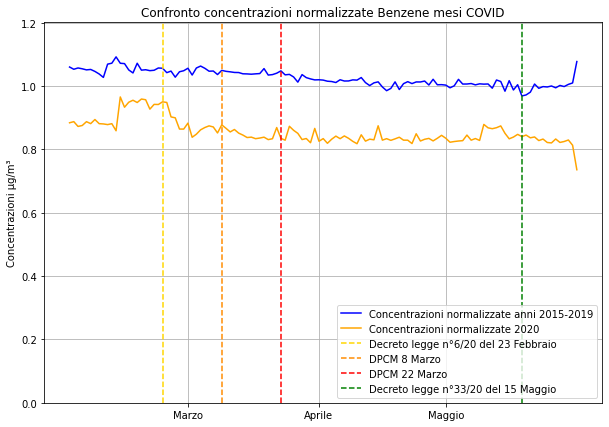

In [64]:
serie_storica_norm, serie2020_norm, datastart = get_data_covid_norm("Benzene")
ymax = max([max(serie_storica_norm.inquinante), max(serie2020_norm.inquinante)])

plt.plot(serie_storica_norm.index, serie_storica_norm.inquinante, color="blue", label=f"Concentrazioni normalizzate anni {datastart}-2019")
plt.plot(serie2020_norm.index.dayofyear, serie2020_norm.inquinante, color="orange", label="Concentrazioni normalizzate 2020")
plt.axvline(54, linestyle="--", label="Decreto legge n°6/20 del 23 Febbraio", color="gold")
plt.axvline(68, linestyle="--", label="DPCM 8 Marzo", color="darkorange")
plt.axvline(82, linestyle="--", label="DPCM 22 Marzo", color="red")
plt.axvline(139, linestyle="--", label="Decreto legge n°33/20 del 15 Maggio", color="green")
plt.legend()
plt.grid()
plt.ylabel("Concentrazioni µg/m³")
plt.xticks(ticks=ticks_giorni, labels=labels_giorni)
plt.title("Confronto concentrazioni normalizzate Benzene mesi COVID")
plt.ylim(0, ymax + (ymax / 10))
plt.show()

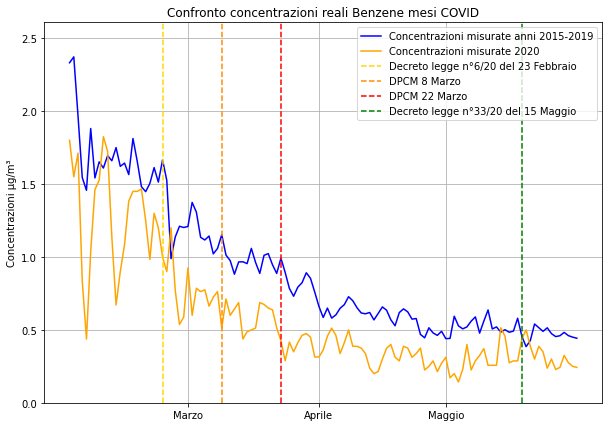

In [66]:
serie_storica, serie2020, datastart = get_data_covid("Benzene")
ymax = max([max(serie_storica.inquinante), max(serie2020.inquinante)])

plt.plot(serie_storica.index, serie_storica.inquinante, color="blue", label=f"Concentrazioni misurate anni {datastart}-2019")
plt.plot(serie2020.index.dayofyear, serie2020.inquinante, color="orange", label="Concentrazioni misurate 2020")
plt.axvline(54, linestyle="--", label="Decreto legge n°6/20 del 23 Febbraio", color="gold")
plt.axvline(68, linestyle="--", label="DPCM 8 Marzo", color="darkorange")
plt.axvline(82, linestyle="--", label="DPCM 22 Marzo", color="red")
plt.axvline(139, linestyle="--", label="Decreto legge n°33/20 del 15 Maggio", color="green")
plt.legend()
plt.grid()
plt.ylabel("Concentrazioni µg/m³")
plt.xticks(ticks=ticks_giorni, labels=labels_giorni)
plt.title("Confronto concentrazioni reali Benzene mesi COVID")
plt.ylim(0, ymax + (ymax / 10))
plt.show()

Anche per questo inquinante, così collegato al traffico, possiamo notare uno scostamento rispetto all'andamento degli anni precedenti abbastanza comptabile con quello visto sugli ossidi di azoto.  
Questo scostamento, confermato anche dalle serie normalizzate, conferma come effettivamente il traffico influenzi le concentrazioni di questo inquinante e quindi come una sua riduzione abbia conseguentemente portato ad un abbassamento delle concentrazioni.  

Sebbene la situazione per quanto riguarda il benzene non desti preoccupazioni, visto che i livelli ormai sono ampiamente sotto alle soglie di legge, abbiamo visto come una riduzione del traffico abbia portato ad un ulteriore miglioramento della situazione per quanto riguarda questo inquinante, che è auspicabile venga portato avanti dall'innovazione tecnologica nel corso dei prossimi anni.

## SO2
Analizziamo l'andamento delle concentrazioni di biossido di zolfo durante i mesi di lockdown, per vedere se notiamo differenze rispetto agli anni precedenti.  

Va detto che, vista la situazione di questo inquinante che lo vede a livelli molto bassi e praticamente prossimi al fondo naturale, non ci possiamo aspettare di vedere grosse differenze, anche perchè ormai le fonti emissive del biossido di zolfo sono state drasticamente ridotte e limitate.

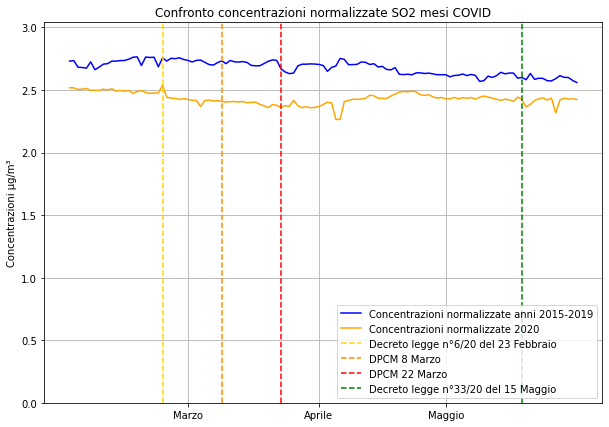

In [68]:
serie_storica_norm, serie2020_norm, datastart = get_data_covid_norm("SO2")
ymax = max([max(serie_storica_norm.inquinante), max(serie2020_norm.inquinante)])

plt.plot(serie_storica_norm.index, serie_storica_norm.inquinante, color="blue", label=f"Concentrazioni normalizzate anni {datastart}-2019")
plt.plot(serie2020_norm.index.dayofyear, serie2020_norm.inquinante, color="orange", label="Concentrazioni normalizzate 2020")
plt.axvline(54, linestyle="--", label="Decreto legge n°6/20 del 23 Febbraio", color="gold")
plt.axvline(68, linestyle="--", label="DPCM 8 Marzo", color="darkorange")
plt.axvline(82, linestyle="--", label="DPCM 22 Marzo", color="red")
plt.axvline(139, linestyle="--", label="Decreto legge n°33/20 del 15 Maggio", color="green")
plt.legend()
plt.grid()
plt.ylabel("Concentrazioni µg/m³")
plt.xticks(ticks=ticks_giorni, labels=labels_giorni)
plt.title("Confronto concentrazioni normalizzate SO2 mesi COVID")
plt.ylim(0, ymax + (ymax / 10))
plt.show()

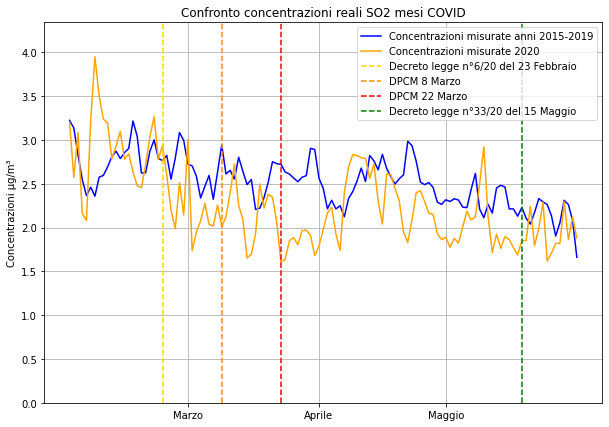

In [70]:
serie_storica, serie2020, datastart = get_data_covid("SO2")
ymax = max([max(serie_storica.inquinante), max(serie2020.inquinante)])

plt.plot(serie_storica.index, serie_storica.inquinante, color="blue", label=f"Concentrazioni misurate anni {datastart}-2019")
plt.plot(serie2020.index.dayofyear, serie2020.inquinante, color="orange", label="Concentrazioni misurate 2020")
plt.axvline(54, linestyle="--", label="Decreto legge n°6/20 del 23 Febbraio", color="gold")
plt.axvline(68, linestyle="--", label="DPCM 8 Marzo", color="darkorange")
plt.axvline(82, linestyle="--", label="DPCM 22 Marzo", color="red")
plt.axvline(139, linestyle="--", label="Decreto legge n°33/20 del 15 Maggio", color="green")
plt.legend()
plt.grid()
plt.ylabel("Concentrazioni µg/m³")
plt.xticks(ticks=ticks_giorni, labels=labels_giorni)
plt.title("Confronto concentrazioni reali SO2 mesi COVID")
plt.ylim(0, ymax + (ymax / 10))
plt.show()

Vediamo infatti come le concentrazioni si siano mantenute su un livello praticamente in linea con quello degli anni precedenti e come anche le serie normalizzate siano piuttosto simili, anche se per il 2020 risulta effettivamente esserci stato un leggero calo, di cui però, vista la modesta quantità, è difficile stabilire se sia dovuto alle limitazioni imposte durante il lockdown o se la sua origine sia anche dovuta ad altri fattori (come ad esempio fluttuazioni nel fondo naturale).

## O3
L'ozono, essendo un inquinante secondario, ha origine molto varie e quindi può essere interessante valutare quali siano state le concentrazioni registrate a seguito dei provvedimenti di lockdown.  

Prima di analizzare la serie va ricordato che l'ozono è l'unico inquinante per cui le serie normalizzate con l'uso di random forest, con cui abbiamo ottenuto i modelli più precisi tra tutti gli inquinanti considerati, presentano un trend crescente. 

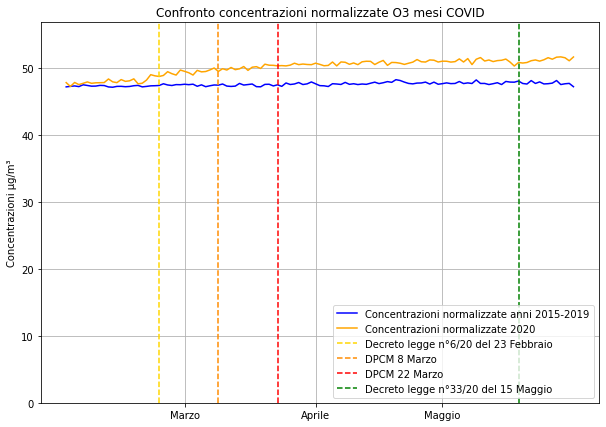

In [72]:
serie_storica_norm, serie2020_norm, datastart = get_data_covid_norm("O3")
ymax = max([max(serie_storica_norm.inquinante), max(serie2020_norm.inquinante)])

plt.plot(serie_storica_norm.index, serie_storica_norm.inquinante, color="blue", label=f"Concentrazioni normalizzate anni {datastart}-2019")
plt.plot(serie2020_norm.index.dayofyear, serie2020_norm.inquinante, color="orange", label="Concentrazioni normalizzate 2020")
plt.axvline(54, linestyle="--", label="Decreto legge n°6/20 del 23 Febbraio", color="gold")
plt.axvline(68, linestyle="--", label="DPCM 8 Marzo", color="darkorange")
plt.axvline(82, linestyle="--", label="DPCM 22 Marzo", color="red")
plt.axvline(139, linestyle="--", label="Decreto legge n°33/20 del 15 Maggio", color="green")
plt.legend()
plt.grid()
plt.ylabel("Concentrazioni µg/m³")
plt.xticks(ticks=ticks_giorni, labels=labels_giorni)
plt.title("Confronto concentrazioni normalizzate O3 mesi COVID")
plt.ylim(0, ymax + (ymax / 10))
plt.show()

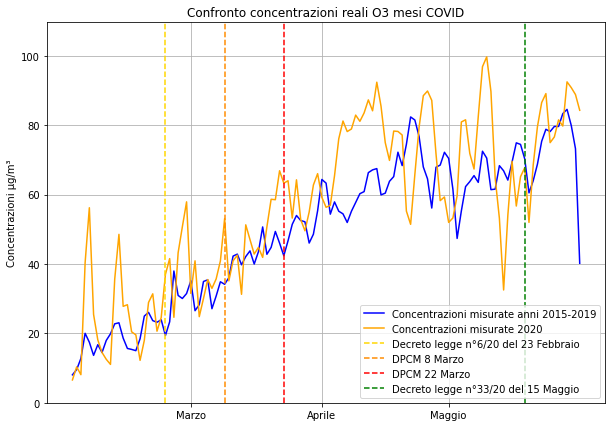

In [74]:
serie_storica, serie2020, datastart = get_data_covid("O3")
ymax = max([max(serie_storica.inquinante), max(serie2020.inquinante)])

plt.plot(serie_storica.index, serie_storica.inquinante, color="blue", label=f"Concentrazioni misurate anni {datastart}-2019")
plt.plot(serie2020.index.dayofyear, serie2020.inquinante, color="orange", label="Concentrazioni misurate 2020")
plt.axvline(54, linestyle="--", label="Decreto legge n°6/20 del 23 Febbraio", color="gold")
plt.axvline(68, linestyle="--", label="DPCM 8 Marzo", color="darkorange")
plt.axvline(82, linestyle="--", label="DPCM 22 Marzo", color="red")
plt.axvline(139, linestyle="--", label="Decreto legge n°33/20 del 15 Maggio", color="green")
plt.legend()
plt.grid()
plt.ylabel("Concentrazioni µg/m³")
plt.xticks(ticks=ticks_giorni, labels=labels_giorni)
plt.title("Confronto concentrazioni reali O3 mesi COVID")
plt.ylim(0, ymax + (ymax / 10))
plt.show()

Vediamo come le concentrazioni per quest'anno si siano mantenute abbastanza in linea con quelle degli anni precedenti mostrando il classico trend crescente dei mesi primaverili che caratterizza questo inquinante, con la serie normalizzata che segnala un aumento, dovuto probabilmente anche alla presenza del trend positivo citato in precedenza.

Nonostante i grossi cambiamenti visti nei mesi di lockdown, quindi, l'ozono non risulta essere stato colpito da tali misure. Questo inquinante, considerate le sue complesse e varie origini, risulta quindi difficile da trattare e trovare misure per il suo contenimento è molto complesso. Abbiamo comunque visto come un blocco generale delle attività non sia stato sufficiente per migliorarne la situazione.

## Ammoniaca
Come ultimo inquinante andiamo a controllare l'andamento dell'ammoniaca, per la quale le serie normalizzate dei nostri modelli avevano individuato un andamento piuttosto fluttuante.

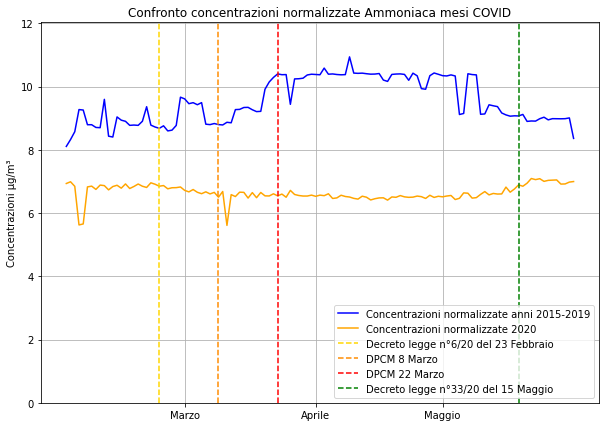

In [76]:
serie_storica_norm, serie2020_norm, datastart = get_data_covid_norm("Ammoniaca")
ymax = max([max(serie_storica_norm.inquinante), max(serie2020_norm.inquinante)])

plt.plot(serie_storica_norm.index, serie_storica_norm.inquinante, color="blue", label=f"Concentrazioni normalizzate anni {datastart}-2019")
plt.plot(serie2020_norm.index.dayofyear, serie2020_norm.inquinante, color="orange", label="Concentrazioni normalizzate 2020")
plt.axvline(54, linestyle="--", label="Decreto legge n°6/20 del 23 Febbraio", color="gold")
plt.axvline(68, linestyle="--", label="DPCM 8 Marzo", color="darkorange")
plt.axvline(82, linestyle="--", label="DPCM 22 Marzo", color="red")
plt.axvline(139, linestyle="--", label="Decreto legge n°33/20 del 15 Maggio", color="green")
plt.legend()
plt.grid()
plt.ylabel("Concentrazioni µg/m³")
plt.xticks(ticks=ticks_giorni, labels=labels_giorni)
plt.title("Confronto concentrazioni normalizzate Ammoniaca mesi COVID")
plt.ylim(0, ymax + (ymax / 10))
plt.show()

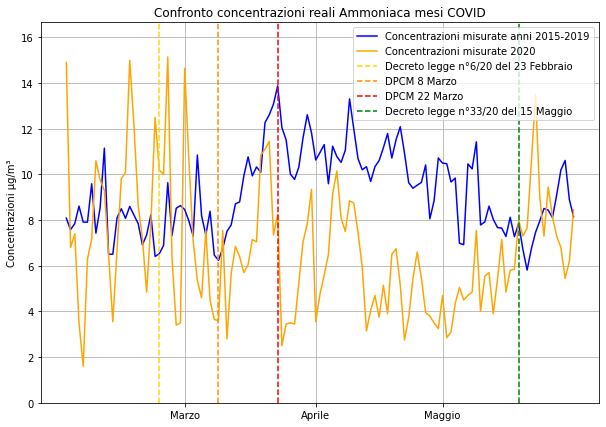

In [78]:
serie_storica, serie2020, datastart = get_data_covid("Ammoniaca")
ymax = max([max(serie_storica.inquinante), max(serie2020.inquinante)])

plt.plot(serie_storica.index, serie_storica.inquinante, color="blue", label=f"Concentrazioni misurate anni {datastart}-2019")
plt.plot(serie2020.index.dayofyear, serie2020.inquinante, color="orange", label="Concentrazioni misurate 2020")
plt.axvline(54, linestyle="--", label="Decreto legge n°6/20 del 23 Febbraio", color="gold")
plt.axvline(68, linestyle="--", label="DPCM 8 Marzo", color="darkorange")
plt.axvline(82, linestyle="--", label="DPCM 22 Marzo", color="red")
plt.axvline(139, linestyle="--", label="Decreto legge n°33/20 del 15 Maggio", color="green")
plt.legend()
plt.grid()
plt.ylabel("Concentrazioni µg/m³")
plt.xticks(ticks=ticks_giorni, labels=labels_giorni)
plt.title("Confronto concentrazioni reali Ammoniaca mesi COVID")
plt.ylim(0, ymax + (ymax / 10))
plt.show()

Effettivamente controllando le concentrazioni misurate si note come tra Marzo e Maggio si sia visto un effettivo calo dei valori misurati, individuato anche dalle serie normalizzate.  
Questo calo probabilmente deriva da una minor attività anche per quanto riguarda il settore agricolo, che è praticamente l'unico responsabile delle concentrazioni misurate di questo inuqinante, che è stato costretto a rallentare durante i mesi di lockdown. 

Visto il forte collegamento tra questo inquinante e l'agricoltura qualsiasi misura di contenimento delle concentrazioni dovrà necessariamente agire su tale settore, poichè effettivamente con un calo dell'attività si è notato anche un calo nelle concentrazioni rilevate.

## Conclusione
In questo notebook abbiamo quindi provato ad applicare la nostra tecnica per la normalizzazione delle serie degli inquinanti per verificare quale sia stato l'effetto del lockdown sulle concentrazioni misurate e quindi valutare quale possano essere gli interventi più efficaci per il contenimento di ciascuno.

Per quanto riguarda gli ossidi di azoto, il benzene ed il monossido di carbonio abbiamo visto come effettivamente si possa notare un calo delle concentrazioni rispetto agli anni precedenti durante i mesi di lockdown. Tale calo, visibile già dai valori misurati, è stato confermato anche dalle serie normalizzate.

Le polveri sottili, invece, essendo collegate a diverse fonti emissive, non hanno fatto registrare cali consistenti rispetto agli anni precedenti, probabilmente perchè c'è stato una compensazione tra settori che hanno ridotto le emissioni e quelli che hanno visto un aumento. Le serie normalizzate hanno mostrato una leggera diminuzione per l'anno 2020 che è però compatibile col trend decrescente individuato dai nostri modelli.

L'ammoniaca, vista la riduzione delle attività agricole, ha fatto registrare un lieve calo rispetto agli anni precedenti, mentre per l'ozono le serie normalizzate rilevano un aumento compatibile col trend crescente già individuato sulla serie.

Si è mostrato quindi come per intervenire sulle concentrazioni di inquinanti vadano previsti piani sia a lungo termine che su larga scala. La situazione per quanto riguarda la Lombardia non è sicuramente preoccupante e l'unico modo per intervenire ulteriormente sulle concentrazioni sembra proprio ridurre le emissioni, tramite il sempre maggior uso di nuove tecnologie e l'impiego di fonti di energia pulite.  
Se persino un periodo come il lockdown, che si è esteso per due mesi e ha visto un'importante riduzione di tutte le attività, ha avuto effetti piuttosto marginali è chiaro come interventi sul breve termine o presi solo per particolari località possano far ben poco per migliorare la situazione.